# Load libraries

In [1]:
import os
import warnings

from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import torch
from torch import nn
import h5py
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

# Read Data

In [2]:
DATA_FOLDER = "../input"

all_paths = [
    os.path.join(path, file) for path, _, files in os.walk(top=DATA_FOLDER)
    for file in files 
    if file.endswith('.labels') or file.endswith('.txt')
]

label_names = {0: 'unlabeled', 
               1: 'man-made terrain', 
               2: 'natural terrain', 
               3: 'high vegetation', 
               4: 'low vegetation', 
               5: 'buildings', 
               6: 'hard scape', 
               7: 'scanning artefacts', 
               8: 'cars'}

all_paths

['../input/sem8_labels_training/sem8_labels_training/sg27_station9_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/bildstein_station5_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/sg28_station4_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/sg27_station4_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/untermaederbrunnen_station3_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/bildstein_station1_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/untermaederbrunnen_station1_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/domfountain_station1_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/neugasse_station1_xyz_intensity_rgb.labels',
 '../input/sem8_labels_training/sem8_labels_training/domfountain_station3_xyz_intensity_rgb.labels',
 '../input/sem8_

In [3]:
all_files_df = pd.DataFrame({'path': all_paths})
all_files_df['basename'] = all_files_df['path'].map(os.path.basename)
all_files_df['id'] = all_files_df['basename'].map(lambda x: os.path.splitext(x)[0])
all_files_df['ext'] = all_files_df['basename'].map(lambda x: os.path.splitext(x)[1][1:])
all_files_df.sample(3)

path  \
16  ../input/bildstein_station1_xyz_intensity_rgb/...   
6   ../input/sem8_labels_training/sem8_labels_trai...   
10  ../input/sem8_labels_training/sem8_labels_trai...   

                                             basename  \
16           bildstein_station1_xyz_intensity_rgb.txt   
6   untermaederbrunnen_station1_xyz_intensity_rgb....   
10                 sg27_station5_intensity_rgb.labels   

                                               id     ext  
16           bildstein_station1_xyz_intensity_rgb     txt  
6   untermaederbrunnen_station1_xyz_intensity_rgb  labels  
10                    sg27_station5_intensity_rgb  labels

In [4]:
all_training_pairs = all_files_df.pivot_table(values = 'path', 
                                              columns = 'ext', 
                                              index = ['id'], 
                                              aggfunc = 'first').reset_index().dropna()
all_training_pairs

ext                                      id  \
0      bildstein_station1_xyz_intensity_rgb   
3    domfountain_station1_xyz_intensity_rgb   

ext                                             labels  \
0    ../input/sem8_labels_training/sem8_labels_trai...   
3    ../input/sem8_labels_training/sem8_labels_trai...   

ext                                                txt  
0    ../input/bildstein_station1_xyz_intensity_rgb/...  
3    ../input/domfountain_station1_xyz_intensity_rg...

In [5]:
_, test_row = next(all_training_pairs.dropna().tail(1).iterrows())
print(test_row)
read_label_data = lambda path, rows: pd.read_table(path, sep = ' ', nrows = rows, names = ['class'], index_col = False)
read_xyz_data = lambda path, rows: pd.read_table(path, sep = ' ', nrows = rows, names = ['x', 'y', 'z', 'intensity', 'r', 'g', 'b'], header = None) #x, y, z, intensity, r, g, b
read_joint_data = lambda c_row, rows: pd.concat([read_xyz_data(c_row['txt'], rows), read_label_data(c_row['labels'], rows)], axis = 1)
read_joint_data(test_row, 10)

ext
id                   domfountain_station1_xyz_intensity_rgb
labels    ../input/sem8_labels_training/sem8_labels_trai...
txt       ../input/domfountain_station1_xyz_intensity_rg...
Name: 3, dtype: object


x       y      z  intensity    r    g    b  class
0 -22.586 -72.368  0.640      -1365  227  226  231      0
1 -22.580 -72.500 -0.009      -1353   82   87  107      0
2 -22.603 -72.498 -0.030      -1367   96  108  134      0
3 -22.511 -72.496 -0.050      -1349   85   82   91      0
4 -22.512 -72.499 -0.037      -1368   83   80   89      0
5 -23.377 -78.032 -0.104      -1543   73   76   85      0
6 -22.535 -72.499 -0.058      -1344   85   84   92      0
7 -22.556 -72.495 -0.053      -1337   80   79   93      0
8 -22.535 -72.497 -0.036      -1367   84   81   90      0
9 -22.721 -72.514 -0.766      -1473   88   80   93      0

In [6]:
df = read_joint_data(test_row, None)
df.shape

(44990641, 8)

In [7]:
le = LabelEncoder()

df["class"] = le.fit_transform(df["class"])
sorted(df["class"].unique())

[0, 1, 2, 3, 4, 5, 6, 7]

# EDA

In [8]:
fraction = 0.1
sample = df.sample(frac=fraction)

CPU times: user 720 ms, sys: 210 ms, total: 930 ms
Wall time: 929 ms


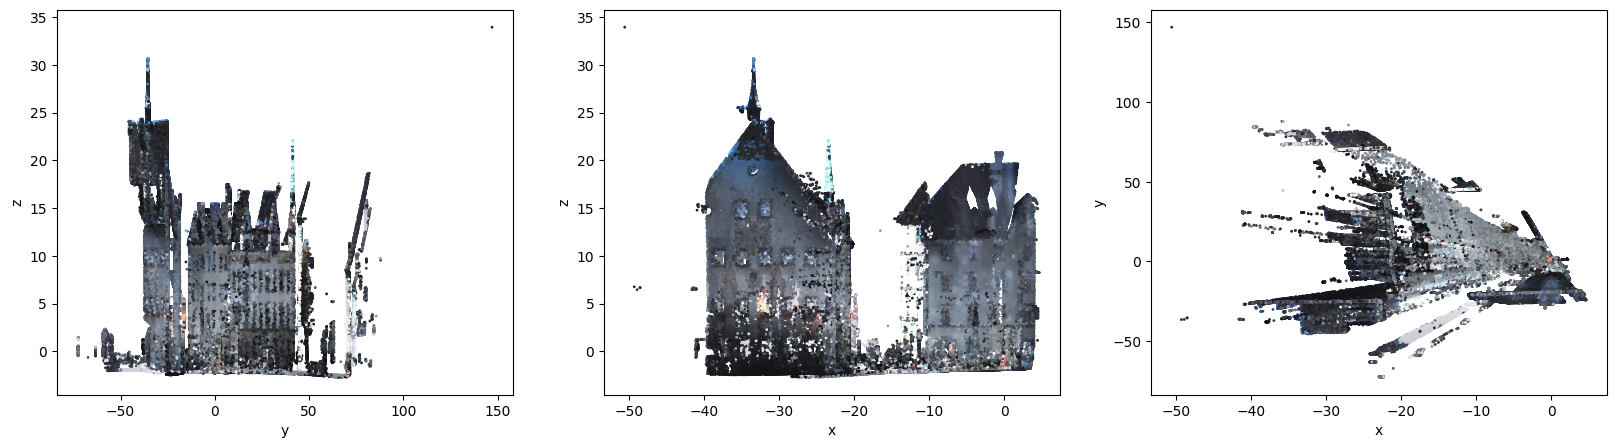

In [9]:
%%time
fig, m_axs = plt.subplots(1, 3, figsize = (20, 5))
ax_names = 'xyz'
for i, c_ax in enumerate(m_axs.flatten()):
    plot_axes = [x for j, x in enumerate(ax_names) if j!=i]
    c_ax.scatter(sample[plot_axes[0]],
                sample[plot_axes[1]],
                c=sample[['r', 'g', 'b']].values / 255, 
                 s=1
                )
    c_ax.set_xlabel(plot_axes[0])
    c_ax.set_ylabel(plot_axes[1])

CPU times: user 1.32 s, sys: 205 ms, total: 1.53 s
Wall time: 1.52 s


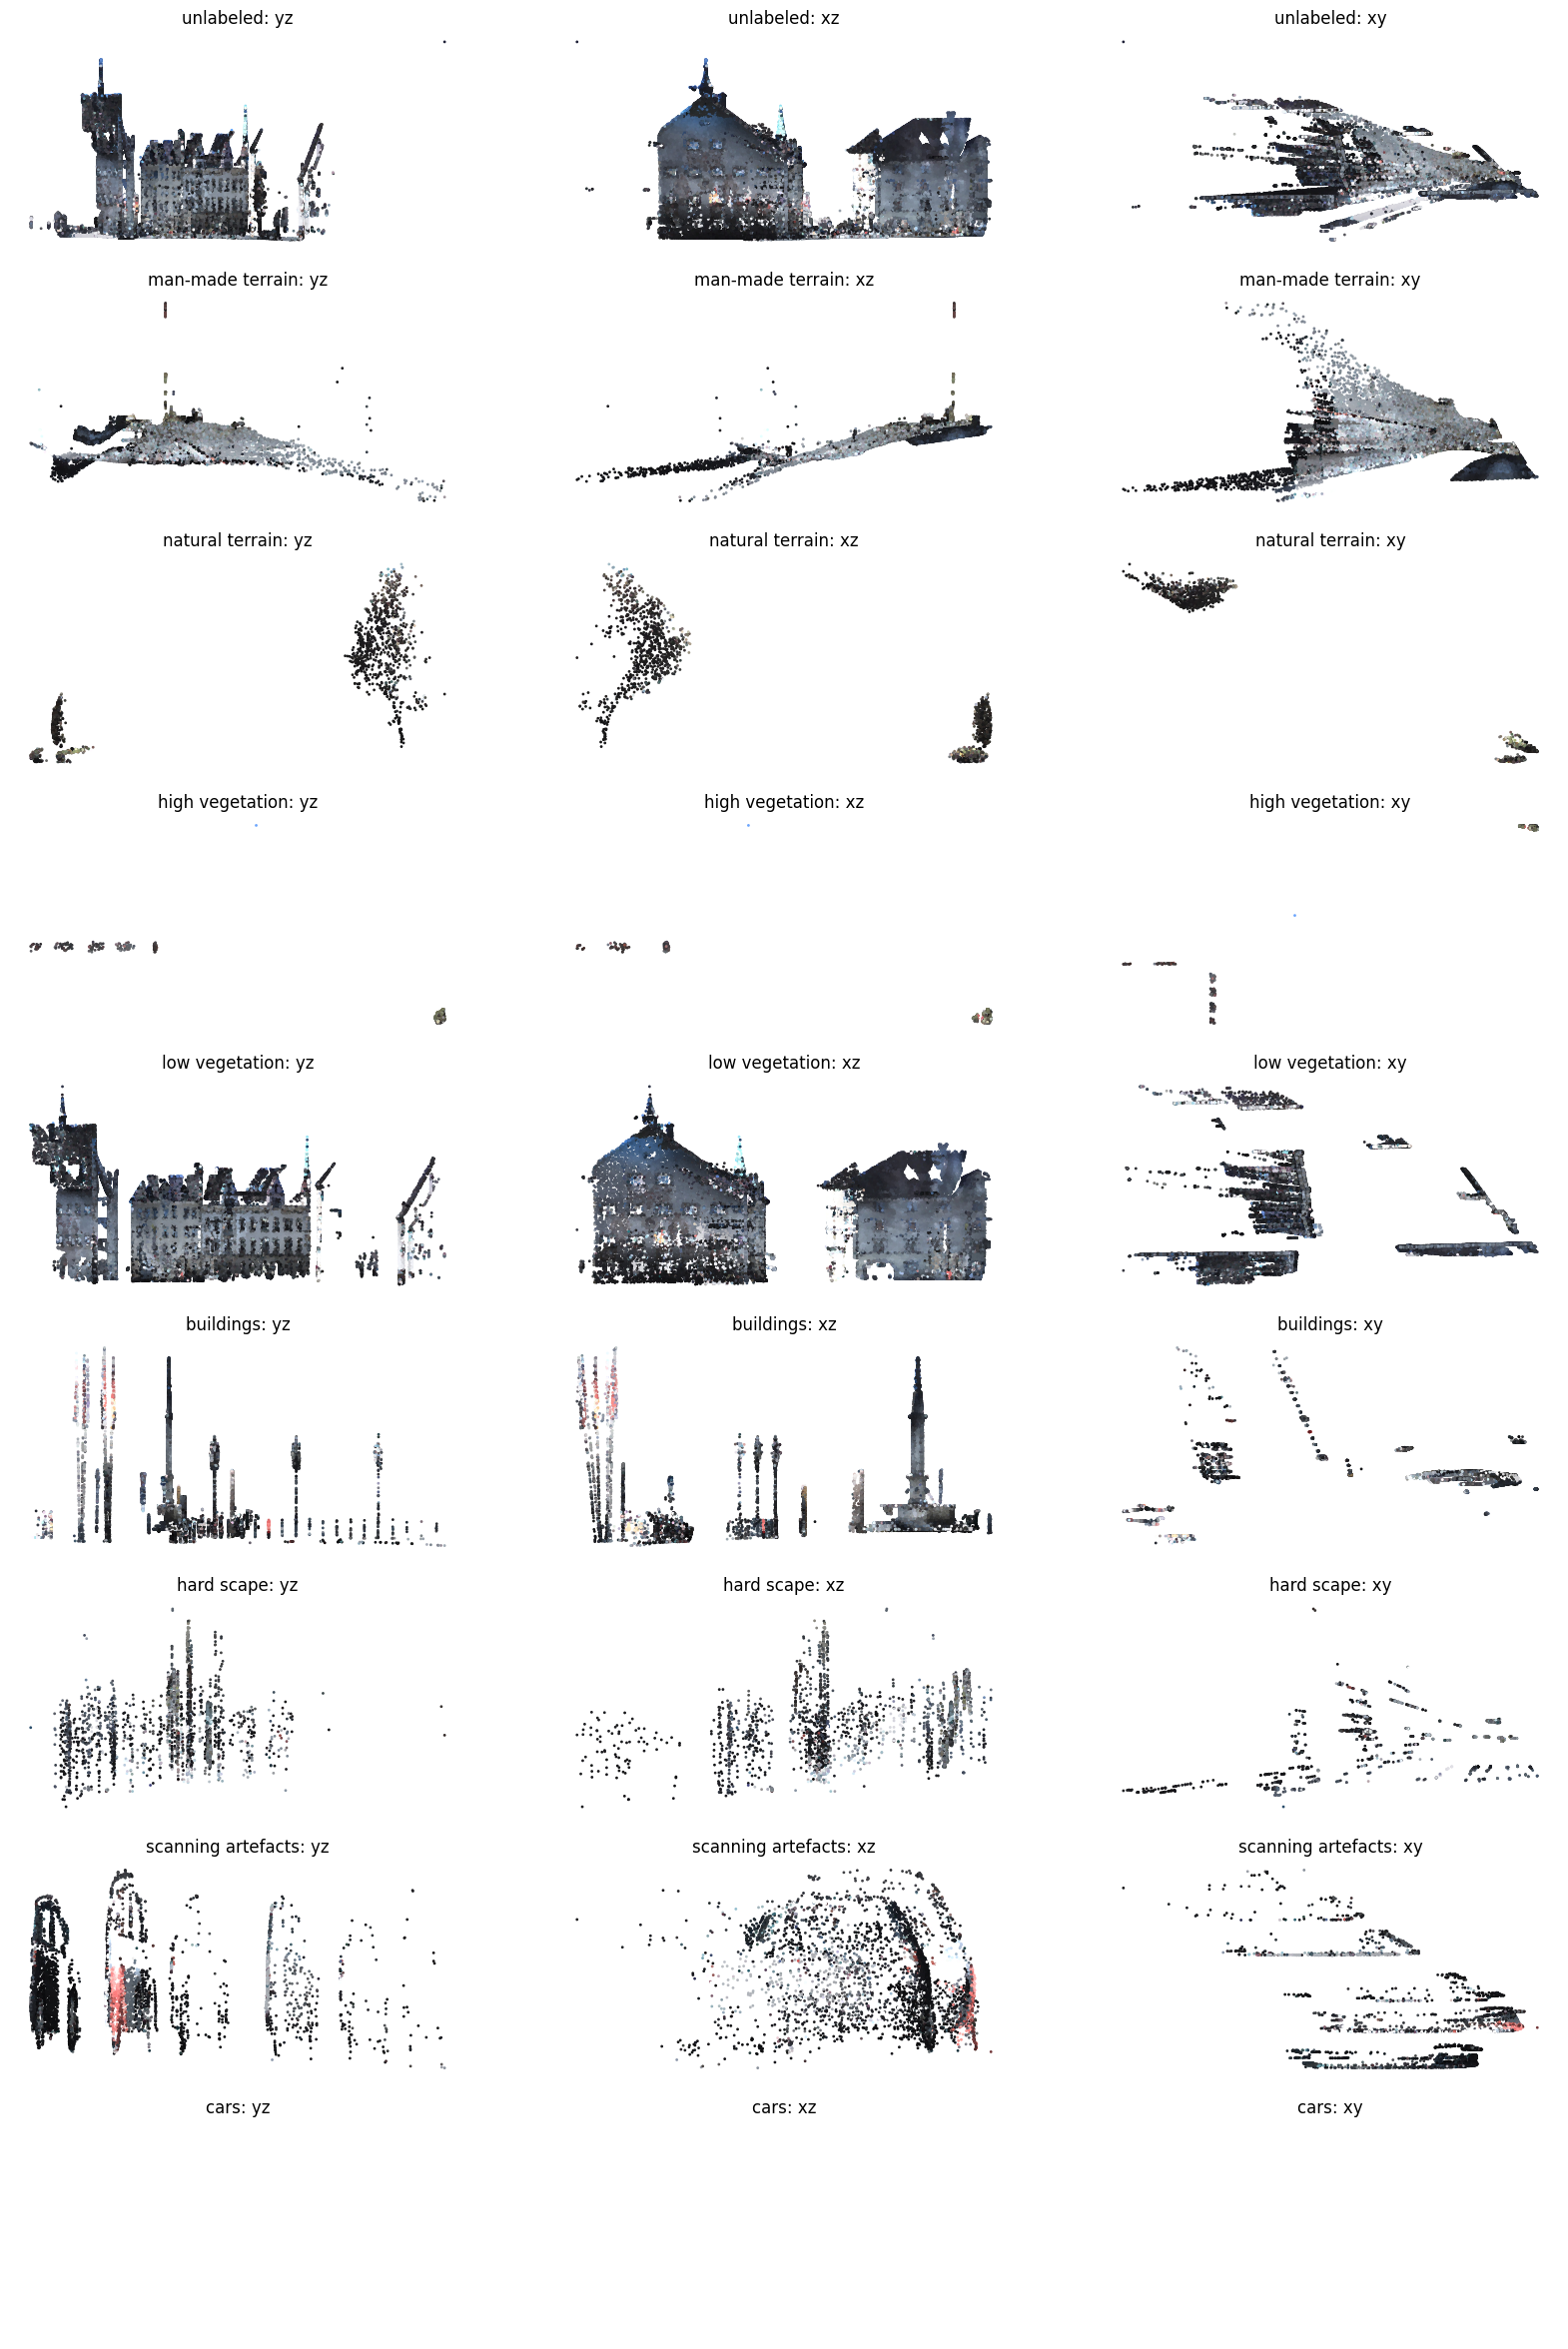

In [10]:
%%time
ax_names = 'xyz'

max_keys = max(label_names.keys())
fig, m_axs = plt.subplots(max_keys + 1, 3, figsize = (20, 30))
for i, c_axs in enumerate(m_axs.T):
    plot_axes = [x for j, x in enumerate(ax_names) if j != i]
    for c_ax, (c_key, c_value) in zip(c_axs, label_names.items()):
        c_df = sample[sample['class'] == c_key]
        c_ax.scatter(
            c_df[plot_axes[0]].values,
            c_df[plot_axes[1]].values,
            c=c_df[["r", "g", "b"]].values / 255,
            label = c_value,
            s=1
        )
        c_ax.set_title('{}: {}'.format(c_value, ''.join(plot_axes)))
        c_ax.set_xlabel(plot_axes[0])
        c_ax.set_ylabel(plot_axes[1])
        c_ax.axis('off')

# Clean data

<Axes: xlabel='z'>

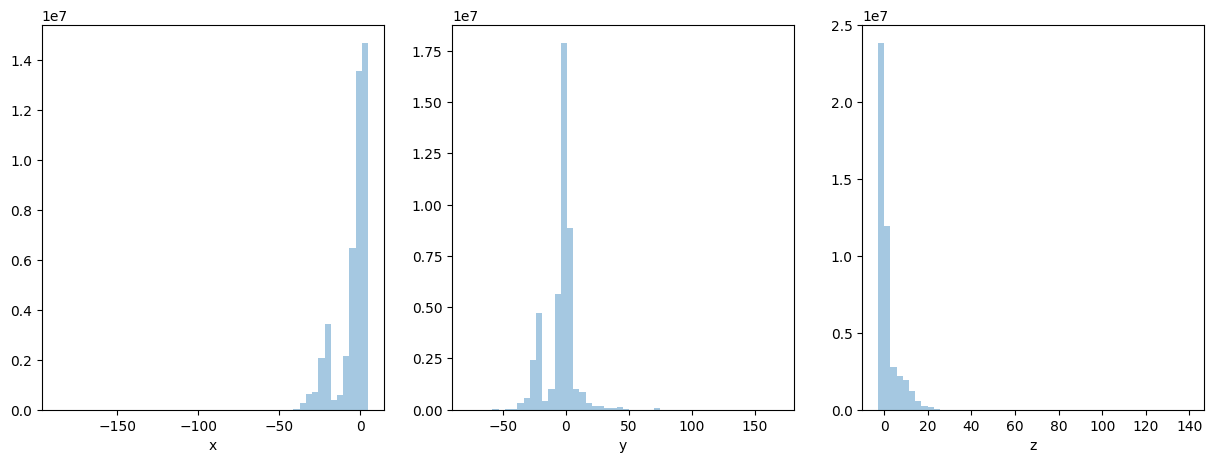

In [11]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)
sns.distplot(df["x"], ax=axs[0], kde=False)
sns.distplot(df["y"], ax=axs[1], kde=False)
sns.distplot(df["z"], ax=axs[2], kde=False)

In [12]:
df = df[
    (-50 <= df["x"]) &
    ((-50 <= df["y"]) & (df["y"] <= 50)) &
    (df["z"] <= 25)
]

In [13]:
df = df.dropna()
df.shape

(44990635, 8)

# BERT

In [14]:
from copy import deepcopy

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

from torch import nn
from transformers import get_constant_schedule

In [15]:
class PointCloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame, features=["x", "y", "z", "intensity", "r", "g", "b"], target_col: str = "class"):
        self.X, self.y = df[features].to_numpy(), df[target_col].to_numpy()
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), self.y[idx]


In [16]:
def train_epoch(model, data_loader, loss_function, optimizer, scheduler, device):
    model.train()

    dl_size = len(data_loader)
    total_train_loss = 0

    logits = []
    targets = []

    for batch in tqdm(data_loader):
        features, batch_target = batch
        features, batch_target = (
            features.float().to(device),
            batch_target.to(device),
        )

        optimizer.zero_grad()
        batch_logits = model(features.unsqueeze(0))

        logits.append(batch_logits.detach().cpu().squeeze(0))
        targets.append(batch_target.cpu())
        
        loss = loss_function(batch_logits.double().squeeze(0), batch_target)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    logits = torch.cat(logits, dim=0)
    targets = torch.cat(targets, dim=0).numpy()
    probas = torch.softmax(logits, dim=1).numpy()
    preds = torch.argmax(logits, dim=1).numpy()
    
    metrics = {
        "Balanced Accuracy": balanced_accuracy_score(targets, preds),
        "Accuracy": accuracy_score(targets, preds),
        "F1 Weighted": f1_score(targets, preds, average='weighted'),
    }
    metrics["loss"] = total_train_loss / dl_size

    return metrics


def eval_epoch(model, data_loader, loss_function, device):
    model.eval()

    dl_size = len(data_loader)
    total_train_loss = 0

    logits = []
    targets = []

    for batch in tqdm(data_loader):
        features, batch_target = batch
        features, batch_target = (
            features.float().to(device),
            batch_target.to(device),
        )

        with torch.no_grad():
            batch_logits = model(features.unsqueeze(0))

            logits.append(batch_logits.detach().cpu().squeeze(0))
            targets.append(batch_target.cpu())
        
        loss = loss_function(batch_logits.squeeze(0), batch_target)
        total_train_loss += loss.item()

    logits = torch.cat(logits, dim=0)
    targets = torch.cat(targets, dim=0).numpy()
    probas = torch.softmax(logits, dim=1).numpy()
    preds = torch.argmax(logits, dim=1).numpy()
    
    metrics = {
        "Balanced Accuracy": balanced_accuracy_score(targets, preds),
        "Accuracy": accuracy_score(targets, preds),
        "F1 Weighted": f1_score(targets, preds, average='weighted'),
    }
    metrics["loss"] = total_train_loss / dl_size

    return metrics


def cross_validation(
        model,
        dataset,
        loss_function,
        optimizer,
        get_scheduler,
        strat_array=None,
        device=torch.device("cuda"),
        random_state: int = 69,
        shuffle: bool = True,
        dataloader_shuffle=False,
        n_folds: int = 4,
        epochs: int = 5,
        lr: float = 1e-6,
        weight_decay: float = 1e-2,
        num_warmup_steps: int = 0,
        start_fold: int = 0,
        batch_size: int = 32,
):
    loss_function.to(device)

    if type(strat_array) != type(None):
        kfold = StratifiedKFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset, strat_array)
    else:
        kfold = KFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset)

    fold_train_scores = []
    fold_eval_scores = []

    for fold, (train_ids, eval_ids) in enumerate(split):
        if fold >= start_fold:
            print(f"FOLD {fold}")
            print("--------------------------------")

            epoch_train_scores = []
            epoch_eval_scores = []

            fold_model = deepcopy(model)
            fold_model.to(device)

            fold_optimizer = optimizer(
                fold_model.parameters(),
                lr=lr,
                weight_decay=weight_decay,
            )

            train_subsampler = torch.utils.data.Subset(dataset, train_ids)
            train_loader = torch.utils.data.DataLoader(
                train_subsampler, 
                batch_size=batch_size, 
                shuffle=dataloader_shuffle
            )

            eval_subsampler = torch.utils.data.Subset(dataset, eval_ids)
            eval_loader = torch.utils.data.DataLoader(
                eval_subsampler, 
                batch_size=batch_size, 
                shuffle=dataloader_shuffle
            )

            total_steps = len(train_loader) * epochs

            if get_scheduler != get_constant_schedule:
                scheduler = get_scheduler(
                    fold_optimizer,
                    num_warmup_steps=num_warmup_steps,
                    num_training_steps=total_steps
                )
            else:
                scheduler = get_scheduler(
                    fold_optimizer,
                )

            for epoch_i in range(epochs):
                train_metrics = train_epoch(
                    fold_model,
                    train_loader,
                    loss_function,
                    fold_optimizer,
                    scheduler,
                    device,
                )
                eval_metrics = eval_epoch(
                    fold_model,
                    eval_loader,
                    loss_function,
                    device,
                )

                epoch_train_scores.append(train_metrics)
                epoch_eval_scores.append(eval_metrics)

                print(f"EPOCH: {epoch_i}")
                print(train_metrics)
                print(eval_metrics)

        fold_train_scores.append(epoch_train_scores)
        fold_eval_scores.append(epoch_eval_scores)

    return fold_train_scores, fold_eval_scores

In [17]:
train, test = train_test_split(
    df,
    stratify=df["class"], 
    test_size=0.2
)

In [ ]:
def weights_init_xavier(m):
    '''
    Xavier uniform
    '''
    classname = m.__class__.__name__

    if classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [18]:
class PointBERT(nn.Module):
    def __init__(
        self,
        input_dim: int = 7, 
        output_dim: int = 8, 
        hidden_dim: int = 128
    ):
        super().__init__()
        
        self.in_norm = nn.BatchNorm1d(input_dim)
        
        self.in_linear = nn.Linear(input_dim, hidden_dim)
        
        self.bert = nn.Transformer(
            nhead=4, 
            num_encoder_layers=4,
            d_model=hidden_dim,
            dim_feedforward=hidden_dim * 2,
            batch_first=True,
            norm_first=True,
        ).encoder
        
        self.out_linear = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.in_norm(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.in_linear(x)
        x = self.bert(x)
        x = self.out_linear(x)
        return x
    
    
model = PointBERT()
weights_init_xavier(model)

In [19]:
train_dataset = PointCloudDataset(train)

In [20]:
loss = nn.CrossEntropyLoss()

In [ ]:
cross_validation(
        model=model,
        dataset=train_dataset,
        loss_function=loss,
        optimizer=torch.optim.AdamW,
        get_scheduler=get_constant_schedule,
        strat_array=train["class"],
        device="cuda",
        random_state=69,
        shuffle=True,
        dataloader_shuffle=False,
        n_folds=4,
        epochs=5,
        lr=1e-3,
        weight_decay=1e-2,
        num_warmup_steps=0,
        start_fold=0,
        batch_size=2048
)

FOLD 0
--------------------------------


  0%|          | 0/13181 [00:00<?, ?it/s]